In [1]:
county_name = "Broward County"

# For example:
# county_name = "Broward County"

In [2]:
import geopandas as gpd
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns

In [3]:
data = gpd.read_file('https://github.com/geo-di-lab/emerge-lessons/raw/refs/heads/main/docs/data/globe_mosquito.zip')
fl = gpd.read_file('https://github.com/geo-di-lab/emerge-lessons/raw/refs/heads/main/docs/data/florida_counties.geojson')

In [4]:
county = fl.loc[fl['NAMELSAD'] == county_name]

In [5]:
data_county = data.sjoin(county, how="inner", predicate="within")

num_total = len(data_county)

print(f"There were {num_total} GLOBE Mosquito Habitat Mapper points recorded within {county_name} from 2018 to 2024 by community scientists.")

if num_total > 0:
    num_eliminated = len(data_county[data_county['BreedingGroundEliminated'] == 'true'])
    print(f"Of those points, {num_eliminated} ({round(num_eliminated * 100 / num_total)}%) mosquito habitats were successfully mitigated by the community scientists, which reduces the risk for mosquitoes at that location in the future.")

There were 43 GLOBE Mosquito Habitat Mapper points recorded within Broward County from 2018 to 2024 by community scientists.
Of those points, 26 (60%) mosquito habitats were successfully mitigated by the community scientists, which reduces the risk for mosquitoes at that location in the future.


In [6]:
data_county.head()

,CountryCode,CountryName,Elevation,AbdomenCloseupPhotoUrls,BreedingGroundEliminated,Comments,DataSource,ExtraData,Genus,GlobeTeams,LarvaFullBodyPhotoUrls,LarvaeCount,LastIdentifyStage,LocationAccuracyM,LocationMethod,MeasuredAt,MeasurementElevation,MeasurementLatitude,MeasurementLongitude,MosquitoAdults,MosquitoEggs,MosquitoHabitatMapperId,MosquitoPupae,Species,Userid,WaterSource,WaterSourcePhotoUrls,WaterSourceType,OrganizationId,OrganizationName,Protocol,SiteId,SiteName,MeasuredDate,LarvaeCountProcessed,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER
6643,USA,United States,-0.4,None,true,When I went kayaking I saw sum in like the tre...,GLOBE Observer App,LarvaeVisibleNo,None,[WileyCollegeBIOL1422],None,0,None,5,automatic,2023-03-30 02:01:00,0,26.1638,-80.1253,None,None,42851,false,None,103027879,"puddle or still water next to a creek, stream ...",https://data.globe.gov/system/photos/2023/03/3...,flowing: still water found next to river or st...,17043304,United States of America Citizen Science,mosquito_habitat_mapper,314904,17RNJ874941,2023-03-30,0.0,POINT (-80.12548 26.16364),57,12,011,00295753,0500000US12011,12011,Broward,Broward County,FL,Florida,06,3115495915,273317277
28674,USA,United States,4.7,None,false,None,GLOBE Observer App,None,None,[SEES2019],None,0,identify,None,None,2019-08-24 11:27:00,0,26.3255,-80.1897,false,false,15439,false,None,57838002,"puddle, vehhicle or animal tracks",https://data.globe.gov/system/photos/2019/08/2...,still: lake/pond/swamp,17043304,United States of America Citizen Science,mosquito_habitat_mapper,160462,17RNK808119,2019-08-24,0.0,POINT (-80.1904 26.32473),57,12,011,00295753,0500000US12011,12011,Broward,Broward County,FL,Florida,06,3115495915,273317277
29024,USA,United States,4.7,None,false,None,GLOBE Observer App,None,None,[SEES2019],None,None,identify,None,None,2019-08-14 19:06:00,0,26.3255,-80.1897,None,None,15169,false,None,57838002,"puddle, vehhicle or animal tracks",https://data.globe.gov/system/photos/2019/08/1...,still: lake/pond/swamp,17043304,United States of America Citizen Science,mosquito_habitat_mapper,160462,17RNK808119,2019-08-14,NaN,POINT (-80.1904 26.32473),57,12,011,00295753,0500000US12011,12011,Broward,Broward County,FL,Florida,06,3115495915,273317277
29395,USA,United States,4.7,None,false,None,GLOBE Observer App,None,None,[SEES2019],None,None,identify,None,None,2019-08-04 16:29:00,0,26.3257,-80.1900,None,None,14785,false,None,57838002,adult mosquito trap,https://data.globe.gov/system/photos/2019/08/0...,container: artificial,17043304,United States of America Citizen Science,mosquito_habitat_mapper,160293,17RNK808120,2019-08-04,NaN,POINT (-80.1904 26.32564),57,12,011,00295753,0500000US12011,12011,Broward,Broward County,FL,Florida,06,3115495915,273317277
29409,USA,United States,4.7,None,false,None,GLOBE Observer App,None,None,[SEES2019],None,None,identify,None,None,2019-08-04 16:28:00,0,26.3254,-80.1899,None,None,14783,false,None,57838002,adult mosquito trap,https://data.globe.gov/system/photos/2019/08/0...,container: artificial,17043304,United States of America Citizen Science,mosquito_habitat_mapper,160462,17RNK808119,2019-08-04,NaN,POINT (-80.1904 26.32473),57,12,011,00295753,0500000US12011,12011,Broward,Broward County,FL,Florida,06,3115495915,273317277


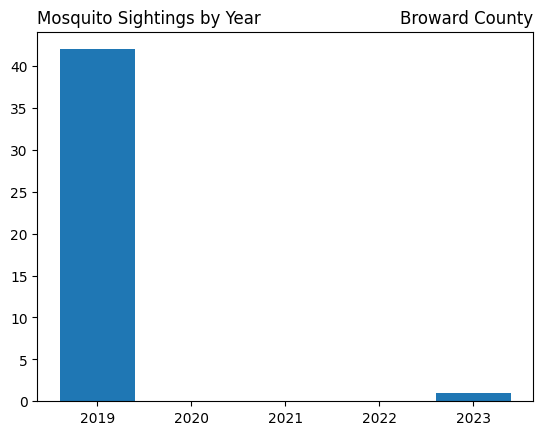

In [7]:
# Add a new column for year
data_county['MeasuredYear'] = data_county['MeasuredAt'].dt.year

# Make histogram of mosquito sightings each year
years = data_county[['SiteId', 'MeasuredYear']].groupby('MeasuredYear', as_index=False).count()
plt.bar(years['MeasuredYear'], years['SiteId'])
plt.title("Mosquito Sightings by Year", loc = 'left')
plt.title(county_name, loc = 'right')
plt.show()

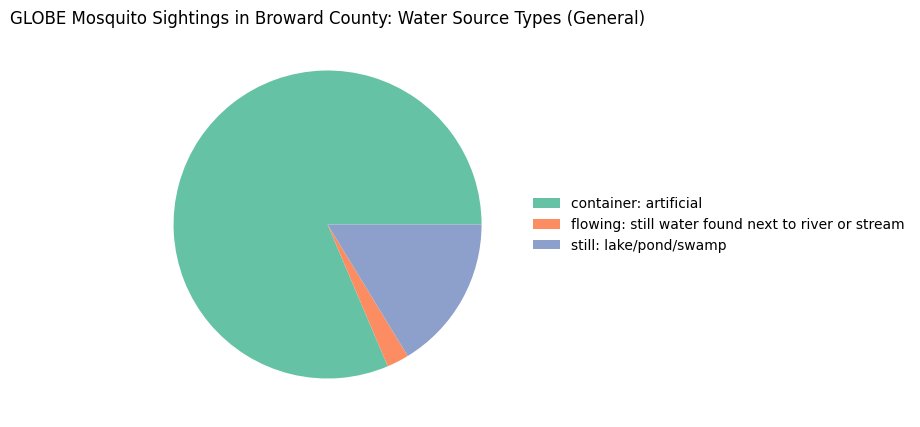

In [8]:
types = data_county[['SiteId', 'WaterSourceType']].groupby('WaterSourceType', as_index=False).count()

plt.figure(figsize=(5, 5))
patches, texts = plt.pie(x = types['SiteId'],
                         colors = sns.color_palette('Set2'))
plt.title(f"GLOBE Mosquito Sightings in {county_name}: Water Source Types (General)")
plt.legend(patches, types['WaterSourceType'],
           loc = 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

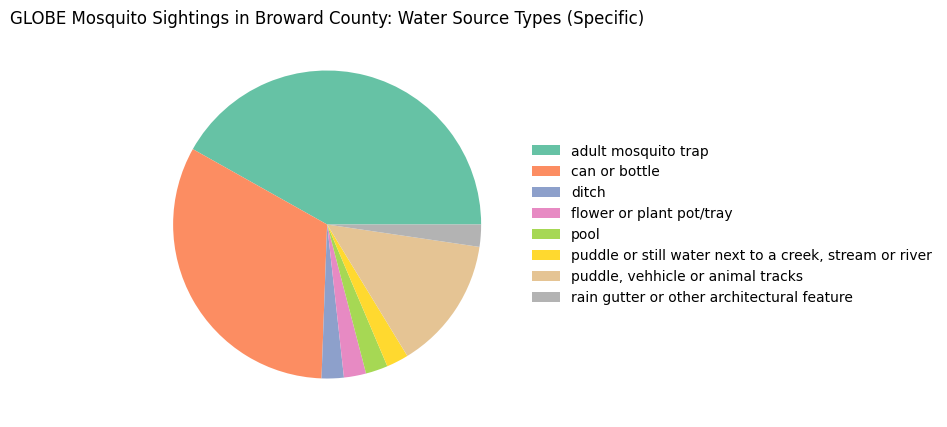

In [9]:
types = data_county[['SiteId', 'WaterSource']].groupby('WaterSource', as_index=False).count()

plt.figure(figsize=(5, 5))
patches, texts = plt.pie(x = types['SiteId'],
                         colors = sns.color_palette('Set2'))
plt.title(f"GLOBE Mosquito Sightings in {county_name}: Water Source Types (Specific)")
plt.legend(patches, types['WaterSource'],
           loc = 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

In [10]:
from datetime import datetime
import numpy as np
from pylab import *
import folium
import ee
import geemap
import geopandas as gpd
ee.Authenticate()

# Write your project ID here, in quotes
ee.Initialize(project = "anr-41793")

def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [11]:
# Convert county boundaries to Earth Engine format
region = geemap.geopandas_to_ee(county)

# Zoom to the county
county_center = county.iloc[0].geometry.centroid

map = folium.Map([county_center.y, county_center.x], tiles="Cartodb dark_matter", zoom_start=10)

In [12]:
start_date = "2025-06-01"
end_date = "2025-07-01"

In [13]:
def to_fahrenheit(lst):
  celsius = lst * 0.02 - 273.15
  fahrenheit = celsius * 1.8 + 32
  return fahrenheit

def to_lst(fahrenheit):
  celsius = (fahrenheit - 32) / 1.8
  lst = (celsius + 273.15) / 0.02
  return lst

In [14]:
lst = (
    ee.ImageCollection('MODIS/061/MOD11A1')
      .filterDate(start_date, end_date)
      .select('LST_Day_1km')
      .mean()   # Can also use median() here to get the median instead of the average
      .clip(region)
)

colors = [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]

lst_vis = {
    'min': to_lst(50), # 50 *F
    'max': to_lst(100), # 100 *F
    'palette': colors,
}

map.add_ee_layer(lst, lst_vis, "LST")

display(map)

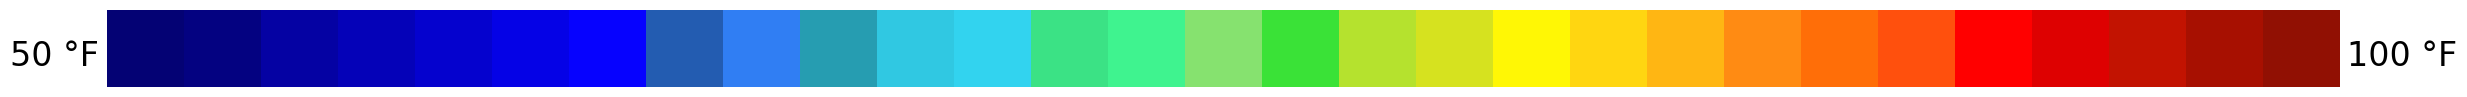

In [15]:
plt.figure(figsize=(len(colors), 1))
plt.imshow([ [to_rgb(f'#{c}') for c in colors] ])

plt.text(-0.6, 0.1, '50 °F', va='center', ha='right', fontsize=24)
plt.text(len(colors) - 0.4, 0.1, '100 °F', va='center', ha='left', fontsize=24)

plt.axis('off')
plt.show()

In [16]:
mean_lst = lst.reduceRegion(reducer=ee.Reducer.mean(), geometry=region, scale=1000,
                              maxPixels=1e12).get('LST_Day_1km').getInfo()

print(f"The average temperature for {county_name} from {start_date} to {end_date} is {round(to_fahrenheit(mean_lst), 2)}°F")

The average temperature for Broward County from 2025-06-01 to 2025-07-01 is 87.67°F


In [17]:
## Land Use

# Reset the map
map = folium.Map([county_center.y, county_center.x], tiles="Cartodb dark_matter", zoom_start=10)

# Define land cover color palette
palette = ['fbff97', 'e6558b', '004e2b', '9dbac5', 'a6976a', '1b1716']
visual = {'min': 1, 'max': 6, 'palette': palette}

landcover_1985 = (
    ee.ImageCollection('USFS/GTAC/LCMS/v2024-10')
      .filterDate('1985', '1986')
      .filter('study_area == "CONUS"')
      .first()
      .clip(region)
)

map.add_ee_layer(landcover_1985.select('Land_Use'), visual, '1985 Land Use')

landcover_2024 = (
    ee.ImageCollection('USFS/GTAC/LCMS/v2024-10')
      .filterDate('2024', '2025')
      .filter('study_area == "CONUS"')
      .first()
      .clip(region)
)

map.add_ee_layer(landcover_2024.select('Land_Use'), visual, '2024 Land Use')

folium.LayerControl(collapsed = False).add_to(map)
display(map)

In [18]:
def land_stats(image, name, labels):
  count = image.select(name).reduceRegion(ee.Reducer.frequencyHistogram(), geometry=region, scale=30, maxPixels=1e12).getInfo()

  land_cover_counts = {}

  for key, value in labels.items():
      if key in count[name]:
          land_cover_counts[value] = count[name][key]

  total_pixels = sum([land_cover_counts[i] for i in land_cover_counts])

  for label, num in land_cover_counts.items():
    percent = round(100 * num / total_pixels, 1)
    if percent > 0:
      print(f"{label}: {percent}%")

In [19]:
land_use_labels = {'1': 'Agriculture',
                   '2': 'Developed',
                   '3': 'Forest',
                   '4': 'Other',
                   '5': 'Rangeland or Pasture',
                   '6': 'Non-Processing Area Mask'}

land_stats(landcover_1985, 'Land_Use', land_use_labels)

Agriculture: 4.5%
Developed: 19.6%
Forest: 8.5%
Other: 9.6%
Rangeland or Pasture: 55.8%
Non-Processing Area Mask: 2.0%


In [20]:
land_stats(landcover_2024, 'Land_Use', land_use_labels)

Agriculture: 0.6%
Developed: 29.4%
Forest: 11.6%
Other: 15.2%
Rangeland or Pasture: 43.1%


In [21]:
## Land Cover

# Reset the map
map = folium.Map([county_center.y, county_center.x], tiles="Cartodb dark_matter", zoom_start=10)

palette = ['004e2b', '009344', '61bb46', 'acbb67', '8b8560', 'cafd4b', 'f89a1c', '8fa55f', 'bebb8e', 'e5e98a', 'ddb925', '893f54', 'e4f5fd', '00b6f0', '1b1716']
visual = {'min': 1, 'max': 15, 'palette': palette}

# Add land cover for 1985 and 2024
map.add_ee_layer(landcover_1985.select('Land_Cover'), visual, '1985 Land Cover')
map.add_ee_layer(landcover_2024.select('Land_Cover'), visual, '2024 Land Cover')

folium.LayerControl(collapsed = False).add_to(map)
display(map)

In [22]:
land_cover_labels = {
    '1': 'Trees',
    '2': 'Tall Shrubs & Trees Mix (AK Only)',
    '3': 'Shrubs & Trees Mix',
    '4': 'Grass/Forb/Herb & Trees Mix',
    '5': 'Barren & Trees Mix',
    '6': 'Tall Shrubs (AK Only)',
    '7': 'Shrubs',
    '8': 'Grass/Forb/Herb & Shrubs Mix',
    '9': 'Barren & Shrubs Mix',
    '10': 'Grass/Forb/Herb',
    '11': 'Barren & Grass/Forb/Herb Mix',
    '12': 'Barren or Impervious',
    '13': 'Snow or Ice',
    '14': 'Water',
    '15': 'Non-Processing Area Mask'
}

In [23]:
land_stats(landcover_1985, 'Land_Cover', land_cover_labels)

Trees: 10.5%
Grass/Forb/Herb & Trees Mix: 1.2%
Grass/Forb/Herb & Shrubs Mix: 0.1%
Grass/Forb/Herb: 61.6%
Barren or Impervious: 16.6%
Water: 8.1%
Non-Processing Area Mask: 2.0%


In [24]:
land_stats(landcover_2024, 'Land_Cover', land_cover_labels)

Trees: 15.7%
Grass/Forb/Herb & Trees Mix: 1.2%
Grass/Forb/Herb & Shrubs Mix: 0.1%
Grass/Forb/Herb: 48.8%
Barren or Impervious: 19.9%
Water: 14.2%
